# Network topology evaluation of adjacencies calculated from expression data
**Authorship:** Adam Klie (last updated: 08/09/2023)<br>
***
**Description:** This notebook takes in any adjacencies calculated on the Parse sequencing of the `igvf_b01_LeftCortex` dataset and uses CellOracle functions to evaluate the network topology of the adjacencies. 
***

# Set-up

In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
# CellOracle
import celloracle as co
from igraph import Graph
co.__version__

/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(

'0.14.0'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [59]:
def read_aracne_out(filename):
    return pd.read_csv(filename, sep='\t')

def read_genie3_out(filename):
    return pd.read_csv(filename, sep='\t')

def read_scenic_out(filename):
    return pd.read_csv(filename, skiprows=3, header=None)

def aracne_out_to_co(
    df,
    copy=False,
):
    """Converts the output of ARACNE to a CellOracle compatible format."""
    if copy:
        df = df.copy()
    df.rename(columns={"Regulator": "source", "Target": "target", "MI": "weight", "pvalue": "p"}, inplace=True)
    df["coef_abs"] = df["weight"].abs()
    return df if copy else None

def genie3_out_to_co(
    df,
    copy=False,
):
    """Converts the output of GENIE3 to a CellOracle compatible format."""
    if copy:
        df = df.copy()
    df.rename(columns={"TF": "source", "importance": "weight"}, inplace=True)
    df["p"] = np.nan
    df["coef_abs"] = df["weight"].abs()
    return df if copy else None

def scenic_out_to_co(
    df
):
    """Co"""
    rows = []
    for i, row in df.iterrows():
        tf = row[0]
        target_string = row[8]
        target_list = target_string.rstrip("]").lstrip("[").split("),")
        for target in target_list:
            target = target.replace("(", "").replace("'", "")
            target_split = target.split(",")
            targ = target_split[0].strip()
            weight = float(target_split[1].strip().strip(")"))
            rows.append([tf, targ, weight])
    return_df = pd.DataFrame(rows, columns=["source", "target", "weight"])
    return_df["p"] = np.nan
    return_df["coef_abs"] = return_df["weight"].abs()
    return return_df

def wgcna_out_to_co(
    df,
):
    """Converts the output of WGCNA to a CellOracle compatible format."""
    df["p"] = np.nan
    df["coef_abs"] = df["weight"].abs()
    df = df[df["source"] != df["target"]]
    return df

In [74]:
output_dir = "/cellar/users/aklie/projects/igvf/topic_grn_links/eval/network_topology/results"
dataset = "Bridge_Satpathy"

In [75]:
if not os.path.exists(os.path.join(output_dir, dataset)):
    os.makedirs(os.path.join(output_dir, dataset))

# Load files

In [61]:
metadata_df = pd.read_csv("/cellar/users/aklie/projects/igvf/topic_grn_links/eval/metadata/Bridge_Satpathy/31Aug23/eval_metadata.tsv", sep="\t")
len(metadata_df)

39

In [62]:
links_dict = {}
for i, row in metadata_df.iterrows():
    method = row["method"]
    file = row["inference_table"]
    name = f"{row['method']}_{row['cells']}_{row['genotype']}_{row['genes']}_{row['normalization']}"
    print(name)
    if method == "aracne":
        df = read_aracne_out(file)
        aracne_out_to_co(df)
    elif method == "celloracle":
        df = pd.read_csv(file, sep="\t")
        df["weight"] = df["coef_abs"]
    elif method in ["genie3", "grnboost2"]:
        df = read_genie3_out(file)
        genie3_out_to_co(df)
    elif method == "scenic":
        df = read_scenic_out(file)
        df = scenic_out_to_co(df)
    elif method == "wgcna":
        df = pd.read_csv(file, sep="\t")
        df = wgcna_out_to_co(df)
    links_dict[name] = df

aracne_balanced_genotype_microglia_B6J_0.05_log1p_cp10k
aracne_balanced_genotype_microglia_CASTJ_0.05_log1p_cp10k
aracne_balanced_genotype_microglia_both_0.05_log1p_cp10k
aracne_balanced_genotype_microglia_B6J_0.05_cpm_rank
aracne_balanced_genotype_microglia_CASTJ_0.05_cpm_rank
aracne_balanced_genotype_microglia_both_0.05_cpm_rank
celloracle_balanced_genotype_microglia_B6J_0.05_raw
celloracle_balanced_genotype_microglia_CASTJ_0.05_raw
celloracle_balanced_genotype_microglia_both_0.05_raw
celloracle_balanced_genotype_microglia_B6J_0.05_log1p_cp10k
celloracle_balanced_genotype_microglia_CASTJ_0.05_log1p_cp10k
celloracle_balanced_genotype_microglia_both_0.05_log1p_cp10k
celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf
celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf
celloracle_balanced_genotype_microglia_both_0.05_pf_log1p_pf
genie3_balanced_genotype_microglia_B6J_0.05_log1p_cp10k
genie3_balanced_genotype_microglia_CASTJ_0.05_log1p_cp10k
genie3_balanced_genotype_mic

In [63]:
len(links_dict)

39

In [64]:
# Make a celloracle links object
links = co.Links(name="Bridge_Satpathy_Microglia_balanced_genotype_microglia_comparison", links_dict=links_dict)

In [65]:
# Filter to top 2000 links
links.filter_links(weight="weight", p=None, threshold_number=2000)

In [66]:
#links.plot_degree_distributions(plot_model=True, save=os.path.join(output_dir, dataset, "network_topology"))

In [67]:
links.filtered_links["wgcna_balanced_genotype_microglia_both_0.05_pf_log1p_pf"]

,source,target,weight,p,coef_abs
2299804,Nnt,Nnt.1,1.000000,NaN,1.000000
419192,Zfp968,Zfp969,1.000000,NaN,1.000000
2862711,Eno1b,G630055G22Rik,0.999590,NaN,0.999590
332020,Prnp,Prn,0.991134,NaN,0.991134
106809,Zc3h11a,Zbed6,0.985116,NaN,0.985116
...,...,...,...,...,...
1762416,Hivep2,Lrrtm4,0.045832,NaN,0.045832
1686491,Rora,Rgs6,0.045831,NaN,0.045831
1920207,Bcl11a,Cadps,0.045823,NaN,0.045823
2971645,Rorb,Adcy2,0.045823,NaN,0.045823


In [68]:
# Calculate network scores.
links.get_network_score()

In [73]:
output_dir, dataset

('/cellar/users/aklie/projectsdd/igvf/topic_grn_links/eval/network_topology/results',
 'Bridge_Satpathy')

In [76]:
# Save gene scores for each gene in the network
gene_scores = links.merged_score
gene_scores.to_csv(os.path.join(output_dir, dataset, "gene_scores_across_runs.tsv"), sep="\t")

# Network hub comparisons

## Pairwise comparisons

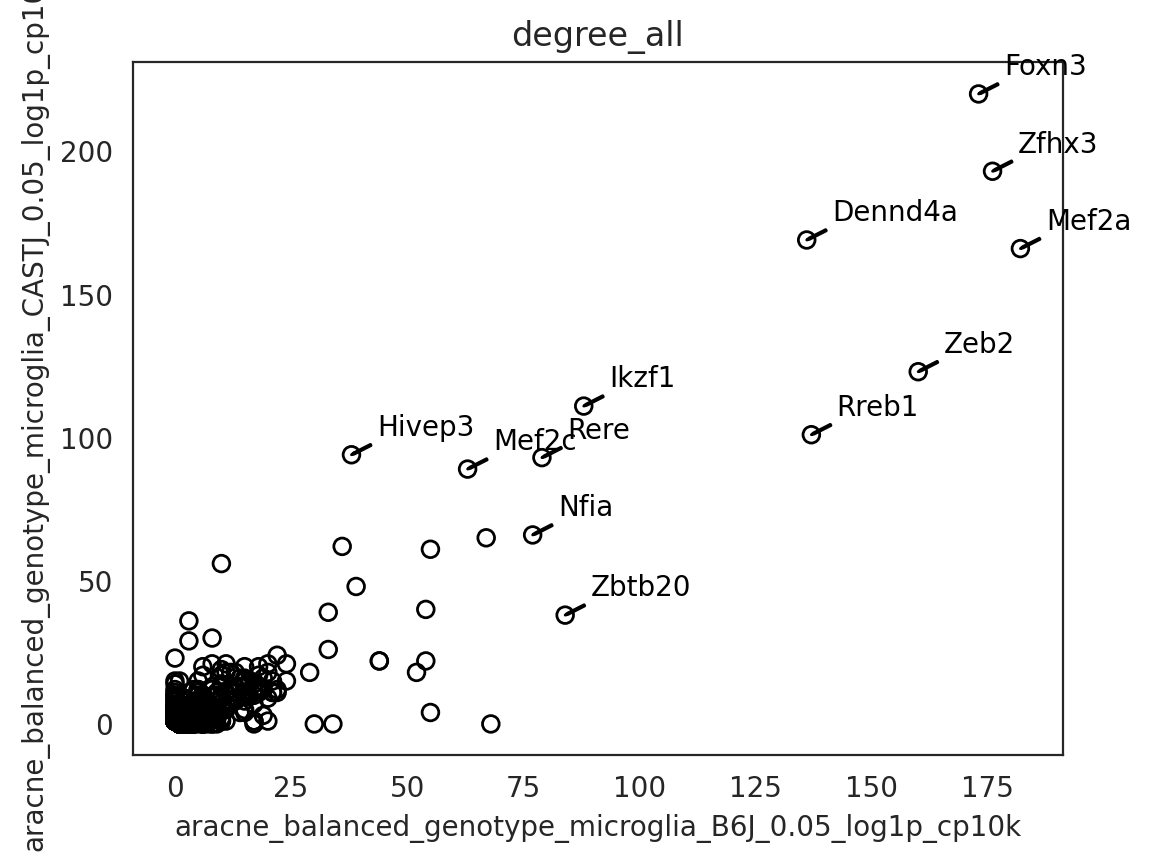

In [83]:
# Cross genotype, same algorithm
links.plot_score_comparison_2D(
    value="degree_all",
    cluster1="aracne_balanced_genotype_microglia_B6J_0.05_log1p_cp10k", 
    cluster2="aracne_balanced_genotype_microglia_CASTJ_0.05_log1p_cp10k",
    percentile=98
)

In [ ]:

links.plot_score_comparison_2D(
    value="degree_all",
    cluster1="celloracle_CASTJ_v1", 
    cluster2="celloracle_B6J_v1",
    percentile=98
)

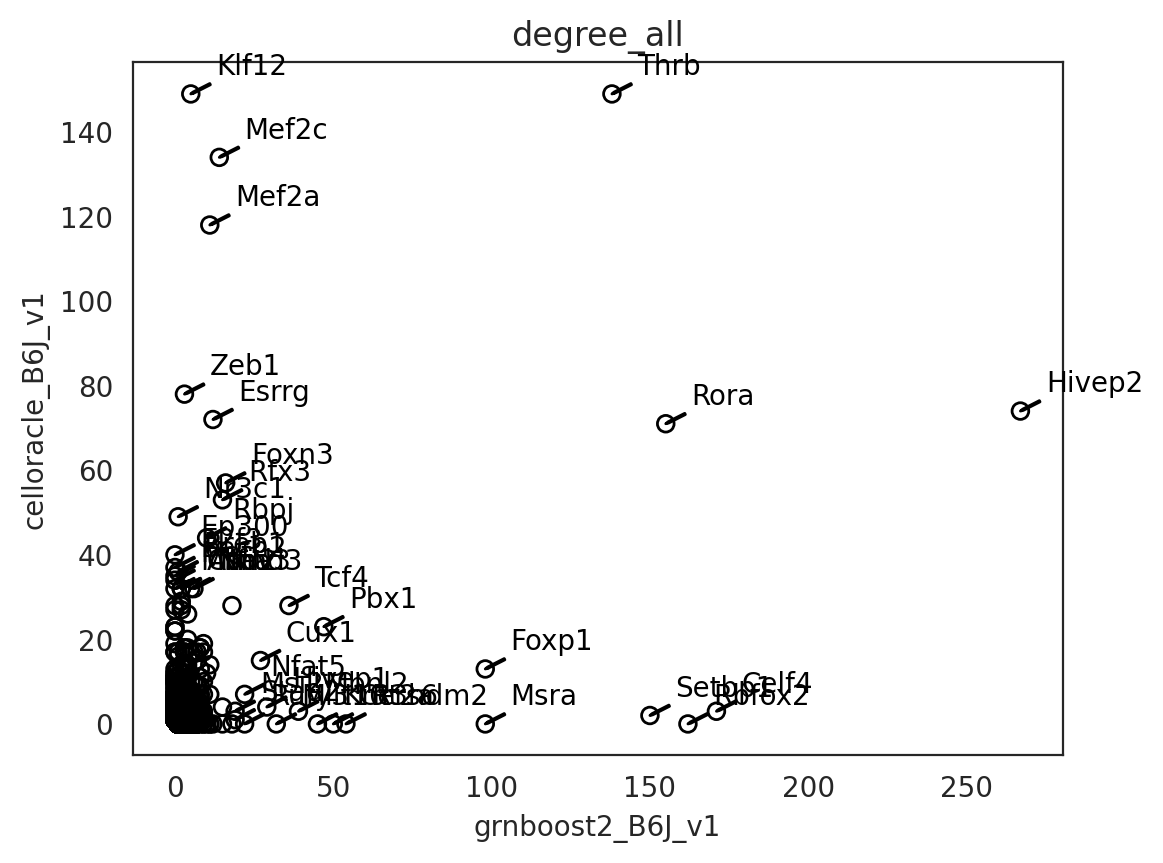

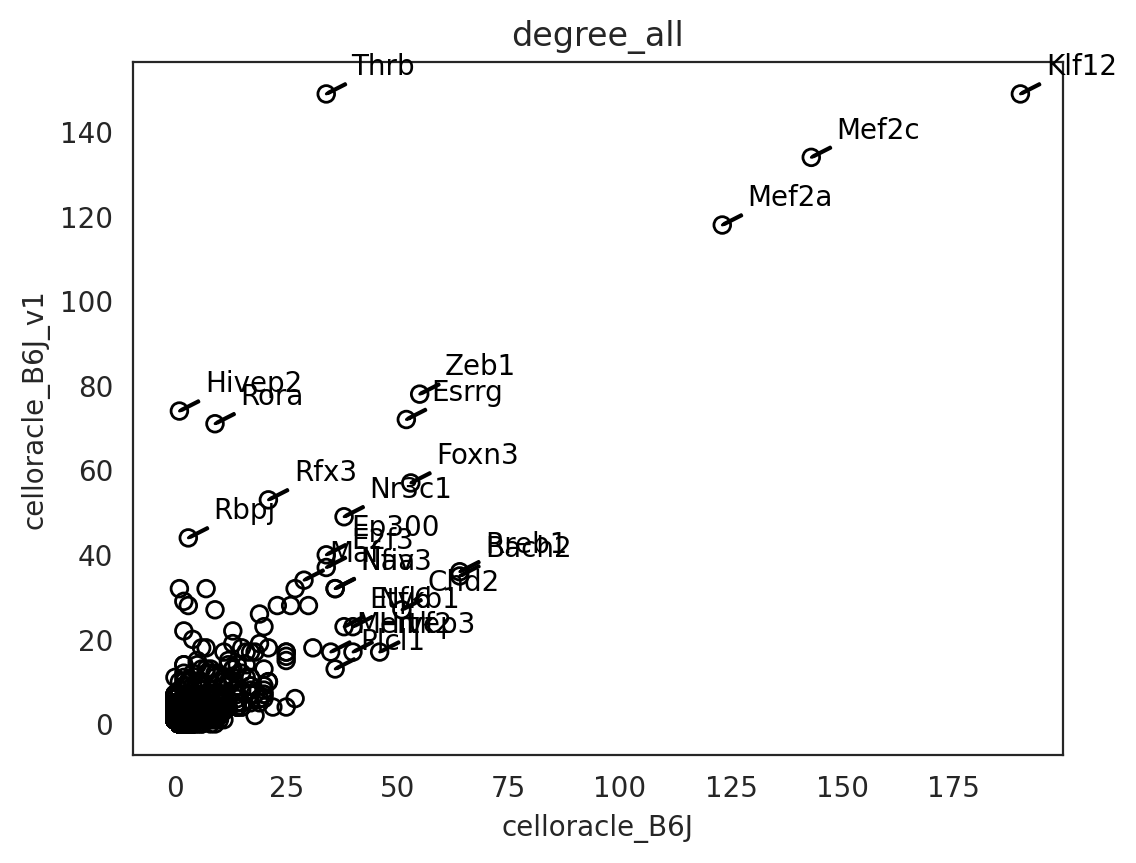

In [30]:
# Same data different algo
links.plot_score_comparison_2D(
    value="degree_all",
    cluster1="grnboost2_B6J_v1", 
    cluster2="celloracle_B6J_v1",
    percentile=98
)
links.plot_score_comparison_2D(
    value="degree_all",
    cluster1="celloracle_B6J", 
    cluster2="celloracle_B6J_v1",
    percentile=98
)

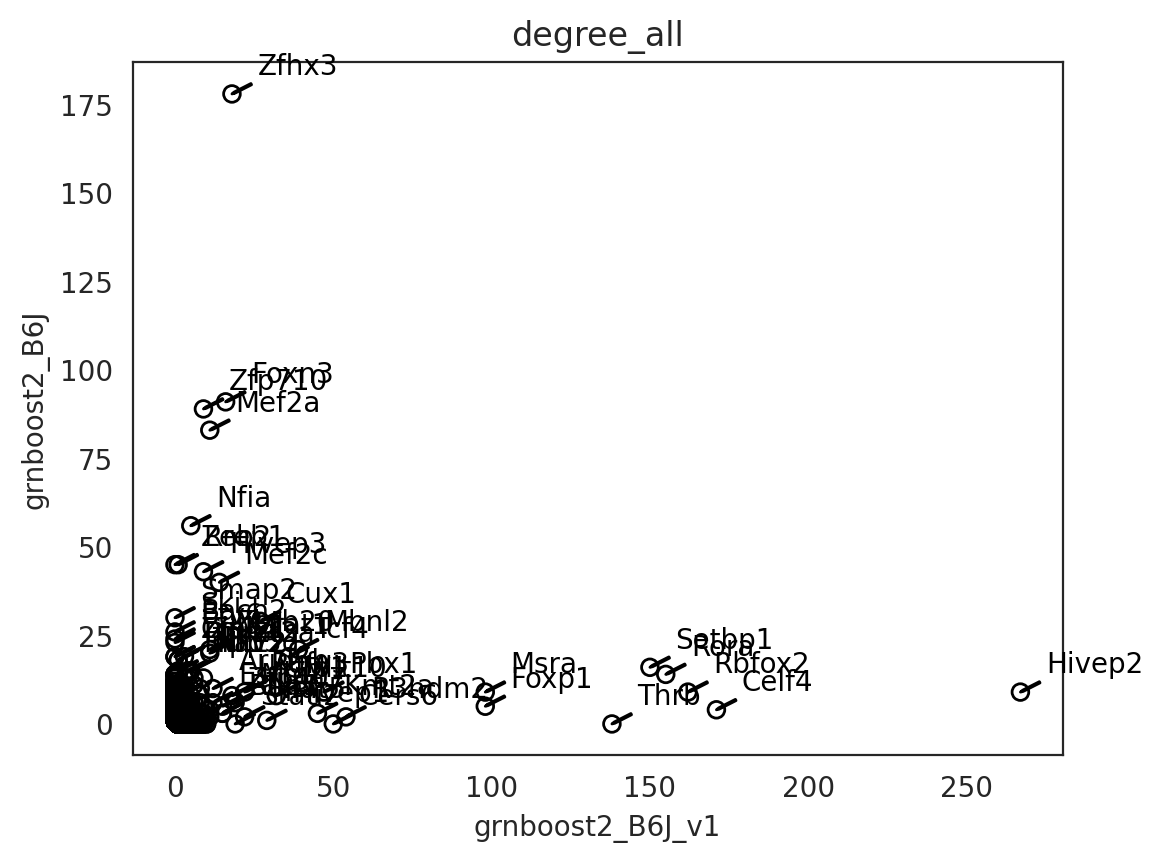

In [31]:
# Same algo different version
links.plot_score_comparison_2D(
    value="degree_all",
    cluster1="grnboost2_B6J_v1", 
    cluster2="grnboost2_B6J",
    percentile=98
)

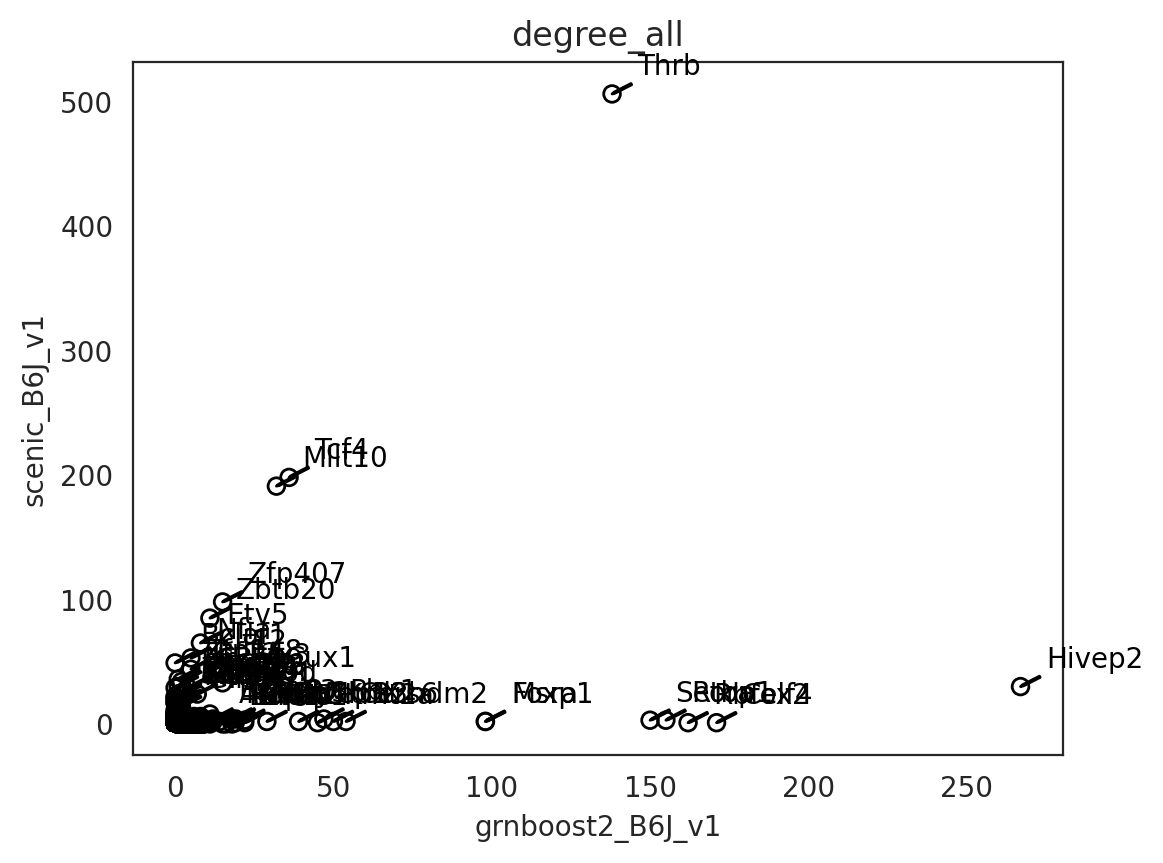

In [32]:
# Confusions
links.plot_score_comparison_2D(
    value="degree_all",
    cluster1="grnboost2_B6J_v1", 
    cluster2="scenic_B6J_v1",
    percentile=98
)

## Gene comparisons

Hivep2


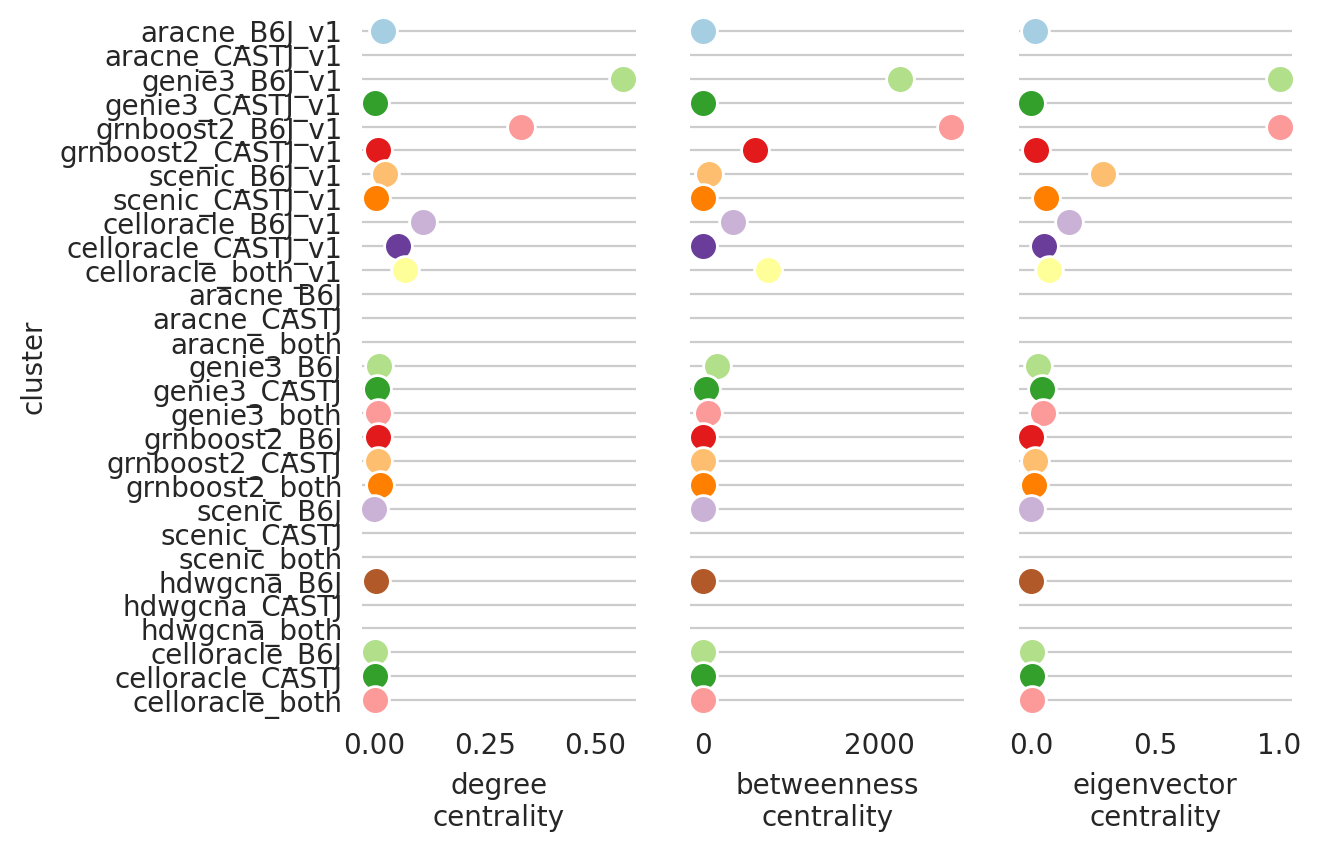

In [33]:
# Certain genes
links.plot_score_per_cluster(goi="Hivep2")

## Across all

In [ ]:
# assign a color to each key in links_dict based on a seaborn palette
palette = sns.color_palette('Paired', len(links_dict))
links.palette = pd.DataFrame({'key': links_dict.keys(), 'palette': palette}).set_index('key')

In [34]:
# Create a dataframe for plotting
plot_df = gene_scores.sort_values("degree_all", ascending=False).groupby("cluster").head(20)
plot_df = plot_df.pivot(columns='cluster', values="degree_all").fillna(0)
plot_df.to_csv(os.path.join(output_dir, dataset, "plot_df.csv"), index=False)

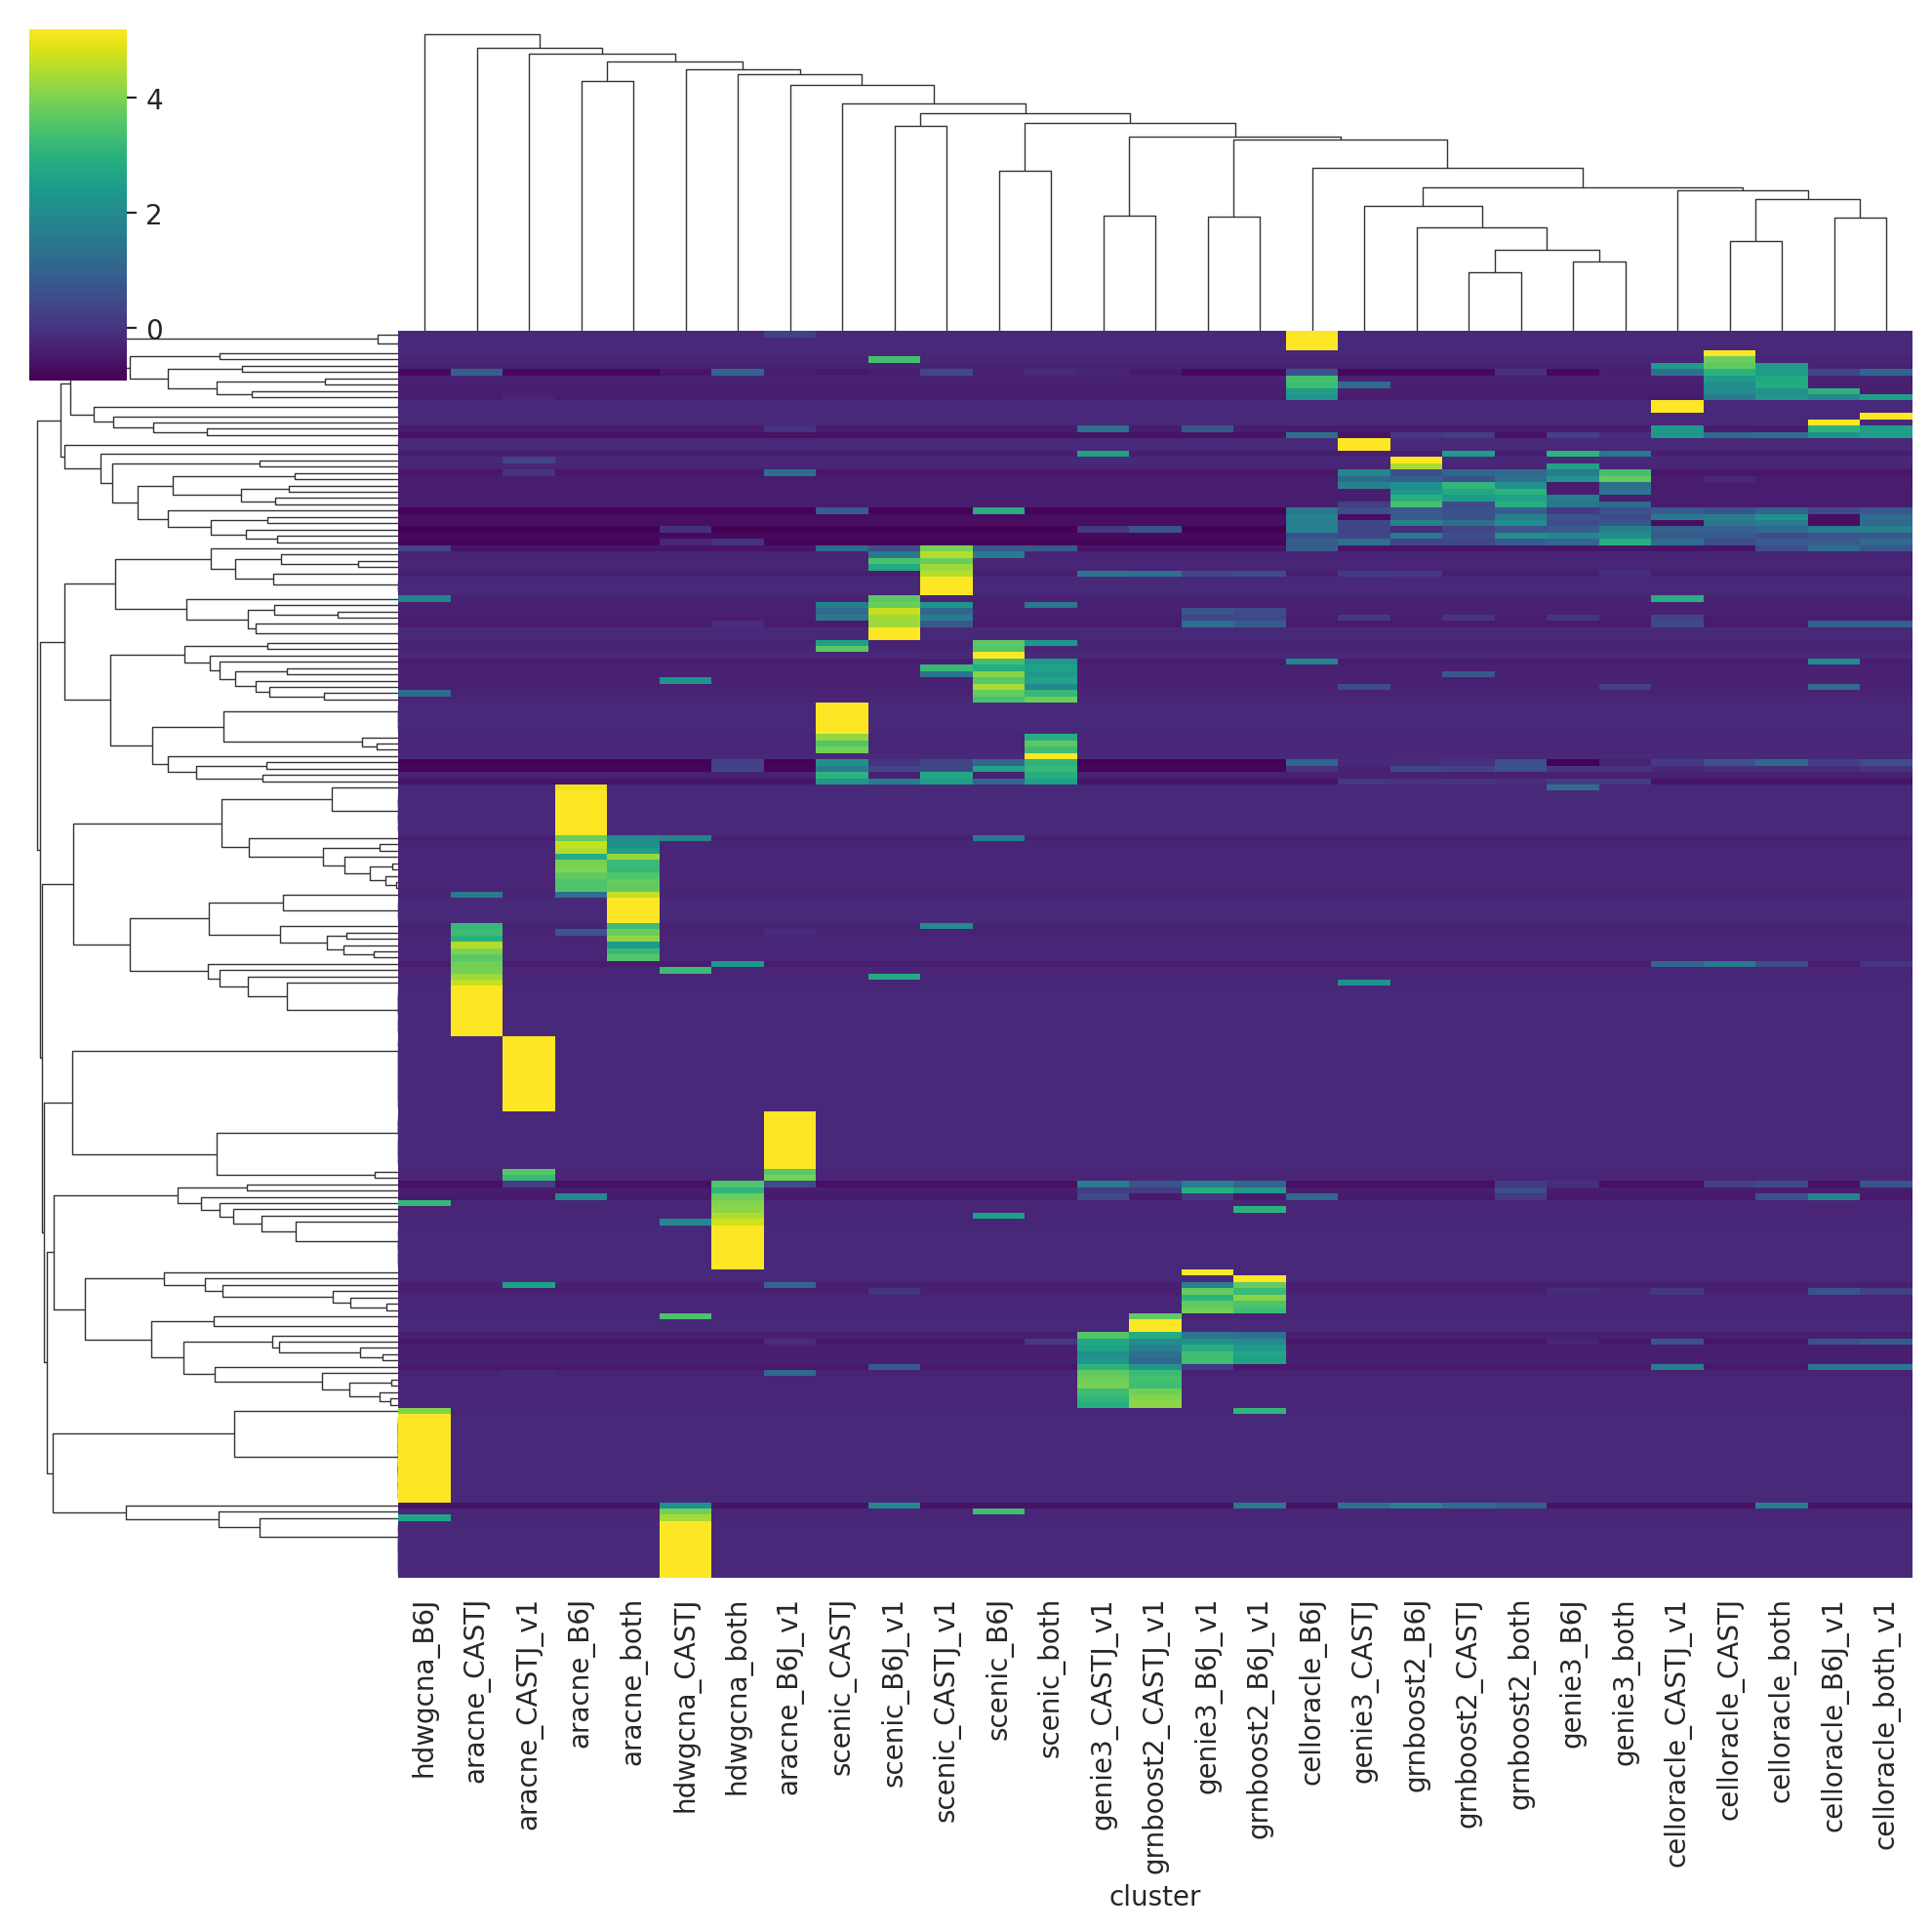

In [36]:
# Clustermap
sns.clustermap(plot_df, cmap="viridis", figsize=(10, 10), row_cluster=True, col_cluster=True, z_score=0, yticklabels=False)

# Adjacency matrix comparisons

## Make adjacency matrices

In [166]:
def links_to_adj_mtx(links_df, adj_genes, weight=None, edge_type="directed"):
    """Turn a CellOracle Links dataframe into an adjacency list
    
    Parameters
    ----------
    links_df : pandas.DataFrame
        A CellOracle Links dataframe. Must have columns "source" and "target".
    
    Returns
    -------
    pd.DataFrame
        Adjacency list representation of the links dataframe. Each row represents a unique "source" node, 
        each column a unique "target" node. The value of each cell should be 1 if there is a row in the input 
        links_df with the corresponding source and target nodes, and 0 otherwise.
    """
    links_df = links_df.reset_index(drop=True)
    adj = pd.DataFrame(0, index=adj_genes, columns=adj_genes)
    for i in range(len(links_df)):
        if weight is None:
            adj.loc[links_df.iloc[i]["source"], links_df.iloc[i]["target"]] = 1
            if edge_type == "undirected":
                adj.loc[links_df.iloc[i]["target"], links_df.iloc[i]["source"]] = 1
        else:
            adj.loc[links_df.iloc[i]["source"], links_df.iloc[i]["target"]] = links_df[weight][i]
            if edge_type == "undirected":
                adj.loc[links_df.iloc[i]["target"], links_df.iloc[i]["source"]] = links_df[weight][i]
    return adj

def binarize_adj_mtx(adj_mtx, threshold=0.0):
    """Turn a weighted adjacency matrix into a binary adjacency matrix

    Parameters
    ----------
    adj_mtx : pandas.DataFrame
        A weighted adjacency matrix
    threshold : float
        The threshold at which to binarize the adjacency matrix
    
    Returns
    -------
    pd.DataFrame
        A binary adjacency matrix
    """
    adj_mtx = adj_mtx.copy()
    adj_mtx[adj_mtx <= threshold] = 0
    adj_mtx[adj_mtx > threshold] = 1
    return adj_mtx

In [ ]:
unique_genes = set()
for name, df in links.filtered_links.items():
    unique_genes.update(df['source'].unique())
    unique_genes.update(df['target'].unique())
unique_genes = gene_scores.index.unique()

In [168]:
weighted_directed_mtx_dict = {}
bin_directed_mtx_dict = {}
for i, key in tqdm(enumerate(links.filtered_links.keys()), total=len(links.filtered_links.keys())):
    print(key)
    weighted_directed_mtx_dict[key] = links_to_adj_mtx(links.filtered_links[key], adj_genes=unique_genes, weight="coef_abs", edge_type="directed")
    bin_directed_mtx_dict[key] = binarize_adj_mtx(weighted_directed_mtx_dict[key], threshold=0.0)
    #if i == 5:
    #    break

  0%|          | 0/29 [00:00<?, ?it/s]

aracne_B6J_v1


aracne_CASTJ_v1
genie3_B6J_v1
genie3_CASTJ_v1
grnboost2_B6J_v1
grnboost2_CASTJ_v1
scenic_B6J_v1
scenic_CASTJ_v1
celloracle_B6J_v1
celloracle_CASTJ_v1
celloracle_both_v1
aracne_B6J
aracne_CASTJ
aracne_both
genie3_B6J
genie3_CASTJ
genie3_both
grnboost2_B6J
grnboost2_CASTJ
grnboost2_both
scenic_B6J
scenic_CASTJ
scenic_both
hdwgcna_B6J
hdwgcna_CASTJ
hdwgcna_both
celloracle_B6J
celloracle_CASTJ
celloracle_both


In [169]:
weighted_undirected_mtx_dict = {}
bin_undirected_mtx_dict = {}
for i, key in tqdm(enumerate(links.filtered_links.keys()), total=len(links.filtered_links.keys())):
    print(key)
    weighted_undirected_mtx_dict[key] = links_to_adj_mtx(links.filtered_links[key], adj_genes=unique_genes, weight="coef_abs", edge_type="undirected")
    bin_undirected_mtx_dict[key] = binarize_adj_mtx(weighted_undirected_mtx_dict[key], threshold=0.0)

  0%|          | 0/29 [00:00<?, ?it/s]

aracne_B6J_v1
aracne_CASTJ_v1
genie3_B6J_v1
genie3_CASTJ_v1
grnboost2_B6J_v1
grnboost2_CASTJ_v1
scenic_B6J_v1
scenic_CASTJ_v1
celloracle_B6J_v1
celloracle_CASTJ_v1
celloracle_both_v1
aracne_B6J
aracne_CASTJ
aracne_both
genie3_B6J
genie3_CASTJ
genie3_both
grnboost2_B6J
grnboost2_CASTJ
grnboost2_both
scenic_B6J
scenic_CASTJ
scenic_both
hdwgcna_B6J
hdwgcna_CASTJ
hdwgcna_both
celloracle_B6J
celloracle_CASTJ
celloracle_both


## Weighted directed comparisons

In [170]:
# Find pairwise correlations of each row of the matrices, but don't include the diagonal or the upper triangle
weighted_directed_corr_df = pd.DataFrame(
    index=list(weighted_directed_mtx_dict.keys()),
    columns=list(weighted_directed_mtx_dict.keys()), 
    data=np.zeros((len(weighted_directed_mtx_dict.keys()), len(weighted_directed_mtx_dict.keys())))
)
weighted_directed_corr_dict = {}
for i in range(0, len(weighted_directed_mtx_dict)):
    for j in range(0, len(weighted_directed_mtx_dict)):
        if i <= j:
            run1 = list(weighted_directed_mtx_dict.keys())[i]
            run2 = list(weighted_directed_mtx_dict.keys())[j]
            print("Comparing " + run1 + " and " + run2)
            mtx1 = weighted_directed_mtx_dict[run1]
            mtx2 = weighted_directed_mtx_dict[run2]
            curr_corr_vec = mtx1.corrwith(mtx2, axis = 1)
            weighted_directed_corr_dict[run1 + "-" + run2] = curr_corr_vec
            weighted_directed_corr_df[run1].loc[run2] = curr_corr_vec.mean()

Comparing aracne_B6J_v1 and aracne_B6J_v1
Comparing aracne_B6J_v1 and aracne_CASTJ_v1
Comparing aracne_B6J_v1 and genie3_B6J_v1
Comparing aracne_B6J_v1 and genie3_CASTJ_v1
Comparing aracne_B6J_v1 and grnboost2_B6J_v1
Comparing aracne_B6J_v1 and grnboost2_CASTJ_v1
Comparing aracne_B6J_v1 and scenic_B6J_v1
Comparing aracne_B6J_v1 and scenic_CASTJ_v1
Comparing aracne_B6J_v1 and celloracle_B6J_v1
Comparing aracne_B6J_v1 and celloracle_CASTJ_v1
Comparing aracne_B6J_v1 and celloracle_both_v1
Comparing aracne_B6J_v1 and aracne_B6J
Comparing aracne_B6J_v1 and aracne_CASTJ
Comparing aracne_B6J_v1 and aracne_both
Comparing aracne_B6J_v1 and genie3_B6J
Comparing aracne_B6J_v1 and genie3_CASTJ
Comparing aracne_B6J_v1 and genie3_both
Comparing aracne_B6J_v1 and grnboost2_B6J
Comparing aracne_B6J_v1 and grnboost2_CASTJ
Comparing aracne_B6J_v1 and grnboost2_both
Comparing aracne_B6J_v1 and scenic_B6J
Comparing aracne_B6J_v1 and scenic_CASTJ
Comparing aracne_B6J_v1 and scenic_both
Comparing aracne_B6J

In [255]:
df1

,A,B,C
0,1,5,11
1,1,8,4
2,1,4,9
3,1,3,3


In [256]:
df2

,A,B,C
0,1,11,4
1,1,2,3
2,1,4,8
3,1,3,5


In [270]:
# Creating the first dataframe
df1 = pd.DataFrame({"A":[1, 1, 1, 1], 
                    "B":[5, 8, 4, 3],
                    "C":[11, 4, 9, 3]})
  
# Creating the second dataframe 
df2 = pd.DataFrame({"A":[1, 1, 1, 2],
                    "B":[11, 3, 4, 3],
                    "C":[4, 3, 8, 5]})
df1.corrwith(df2, axis = 0)

A         NaN
B   -0.039952
C    0.319617
dtype: float64

In [266]:
b6j_adj_mtx.loc["Kmt2a"][b6j_adj_mtx.loc["Kmt2a"] != 0]

Zeb2        1.0
Srrm2       1.0
Kmt2a       1.0
Son         1.0
Klf12       1.0
           ... 
Msrb2       1.0
Vdac2       1.0
Fam114a2    1.0
Bcl9l       1.0
Rala        1.0
Name: Kmt2a, Length: 3606, dtype: float64

In [228]:
mtx1.loc["Zeb2"].sum()

0.0

In [242]:
 mtx2.loc["Nfia"].sum()

24.0

In [241]:
# Np correlation
np.corrcoef(mtx1.loc["Zeb2"], mtx2.loc["Nfia"])

/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


array([[nan, nan],
       [nan,  1.]])

In [238]:
np.nanmean(mtx1.corrwith(mtx2, axis = 1))["Nfia"]

1.0000000000000122

In [245]:
mtx1.corrwith(mtx2, axis = 1)["Nfia"]

nan

In [211]:
curr_corr_vec

Zeb2        NaN
Srrm2       NaN
Kmt2a       NaN
Son         NaN
Klf12       1.0
           ... 
Msrb2       NaN
Vdac2       NaN
Fam114a2    NaN
Bcl9l       NaN
Rala        NaN
Length: 3606, dtype: float64

In [280]:
top25_concordant_genes = pd.DataFrame(weighted_directed_corr_dict).fillna(0).mean(axis=1).sort_values(ascending=False).head(25)

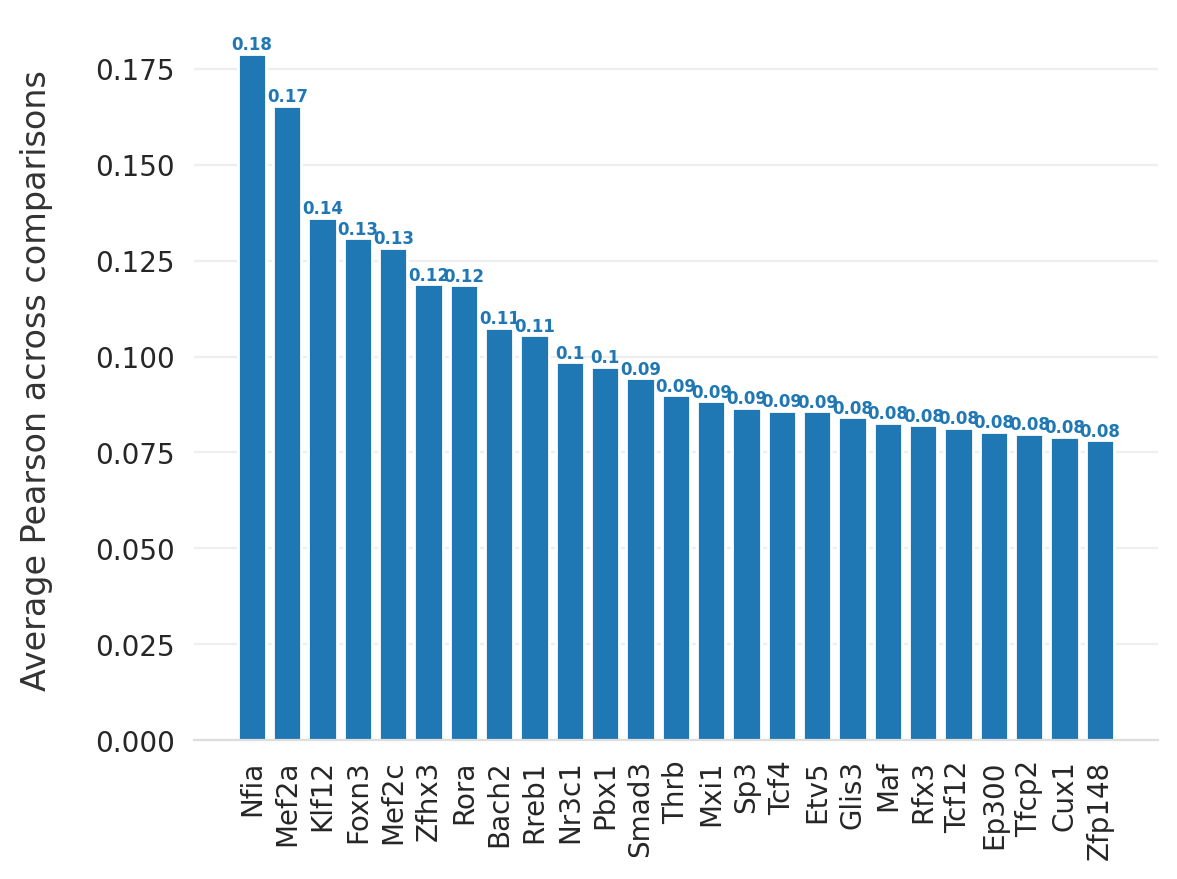

In [295]:
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=top25_concordant_genes.index,
    height=top25_concordant_genes.values,
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Grab the color of the bars so we can make the
# text the same color.
bar_color = bars[0].get_facecolor()

# Add text annotations to the top of the bars.
# Note, you'll have to adjust this slightly (the 0.3)
# with different data.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.001,
      round(bar.get_height(), 2),
      fontsize=6,
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

#rotate xticklabels
plt.xticks(rotation=90)

# xlabel is average pearson correlation across comparisons
ax.set_ylabel('Average Pearson across comparisons', labelpad=15, color='#333333', fontsize=12)
fig.tight_layout()

Nfia


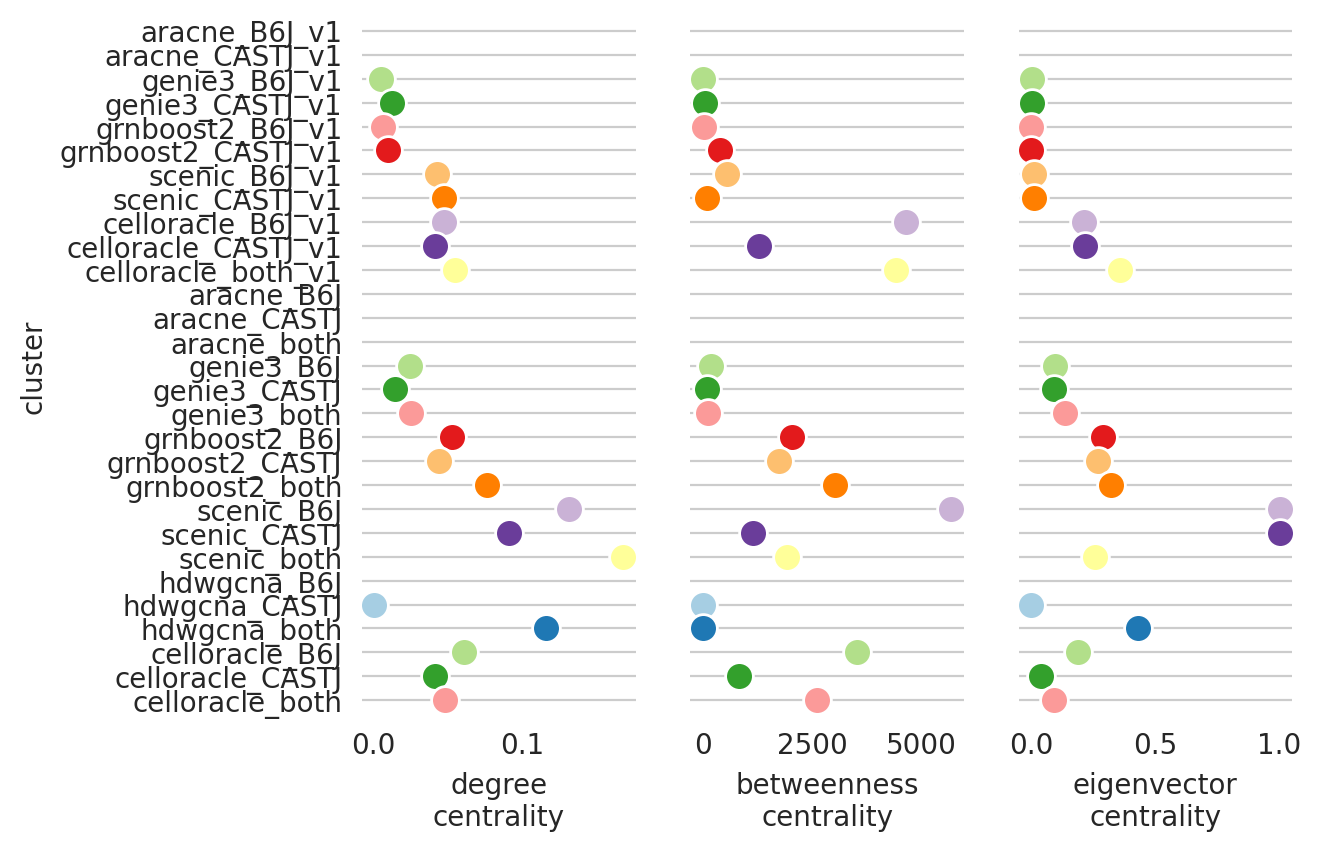

In [299]:
# Certain genes
links.plot_score_per_cluster(goi="Nfia")

Mef2a


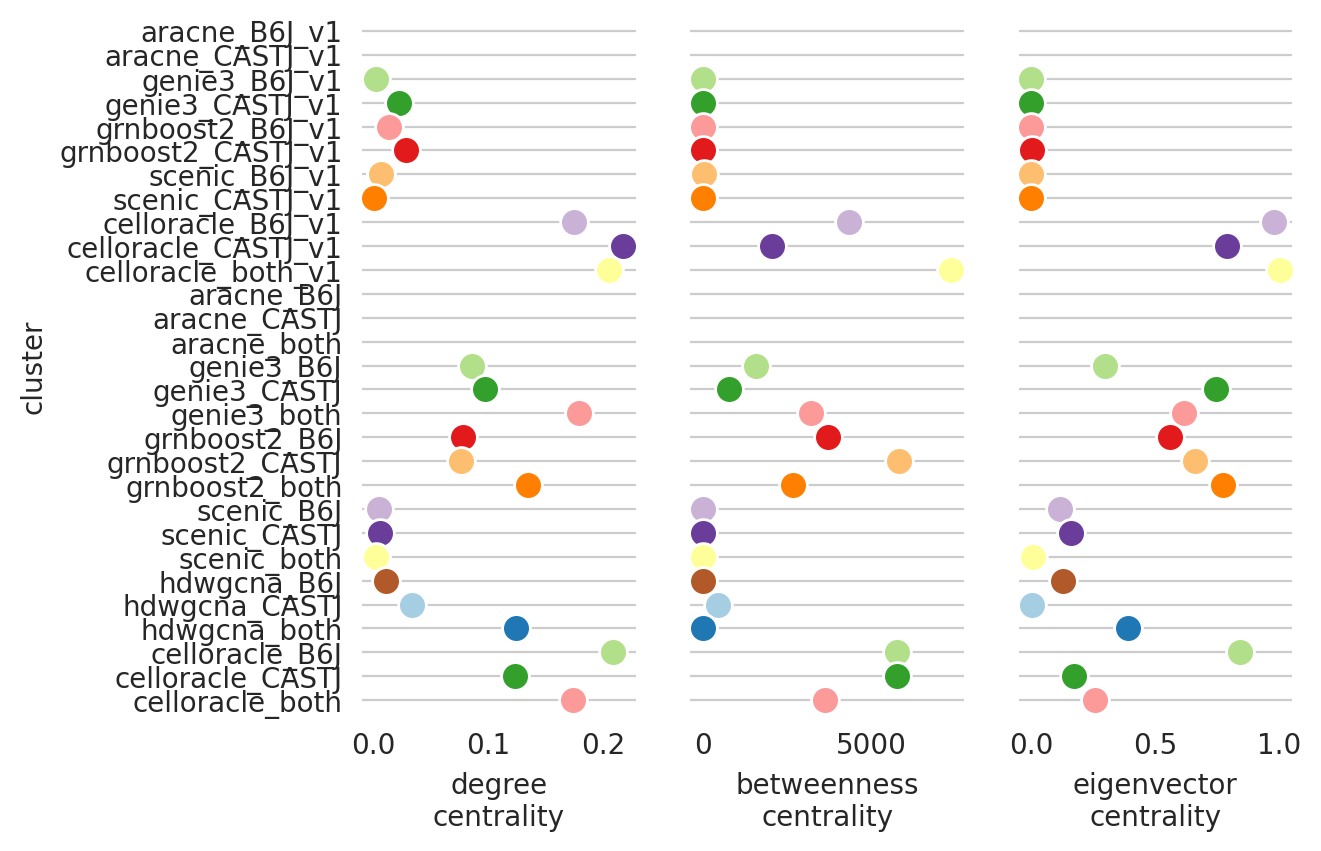

In [300]:
# Certain genes
links.plot_score_per_cluster(goi="Mef2a")

In [298]:
gene_scores.loc["Nfia"]

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
Nfia,3,0.005525,0,0.000000,3,0.005525,0.0,0.002427,genie3_B6J_v1
Nfia,8,0.012780,1,0.001597,7,0.011182,43.0,0.002187,genie3_CASTJ_v1
Nfia,5,0.006227,2,0.002491,3,0.003736,26.0,0.001670,grnboost2_B6J_v1
Nfia,8,0.009816,2,0.002454,6,0.007362,399.0,0.001953,grnboost2_CASTJ_v1
Nfia,53,0.042985,4,0.003244,49,0.039740,565.0,0.010904,scenic_B6J_v1
Nfia,56,0.047660,2,0.001702,54,0.045957,95.0,0.012551,scenic_CASTJ_v1
Nfia,32,0.047407,3,0.004444,29,0.042963,4635.0,0.211822,celloracle_B6J_v1
Nfia,28,0.041420,6,0.008876,22,0.032544,1281.0,0.218554,celloracle_CASTJ_v1
Nfia,38,0.054519,6,0.008608,32,0.045911,4408.0,0.358188,celloracle_both_v1
Nfia,39,0.024590,1,0.000631,38,0.023960,188.0,0.097743,genie3_B6J


In [281]:
# Make a really nice bar plot from this series


Nfia      0.178869
Mef2a     0.165320
Klf12     0.136152
Foxn3     0.130909
Mef2c     0.128322
Zfhx3     0.118853
Rora      0.118510
Bach2     0.107483
Rreb1     0.105524
Nr3c1     0.098576
Pbx1      0.097326
Smad3     0.094350
Thrb      0.089842
Mxi1      0.088299
Sp3       0.086673
Tcf4      0.085884
Etv5      0.085759
Glis3     0.084179
Maf       0.082792
Rfx3      0.082067
Tcf12     0.081465
Ep300     0.080433
Tfcp2     0.079904
Cux1      0.079152
Zfp148    0.078145
dtype: float64

<AxesSubplot: >

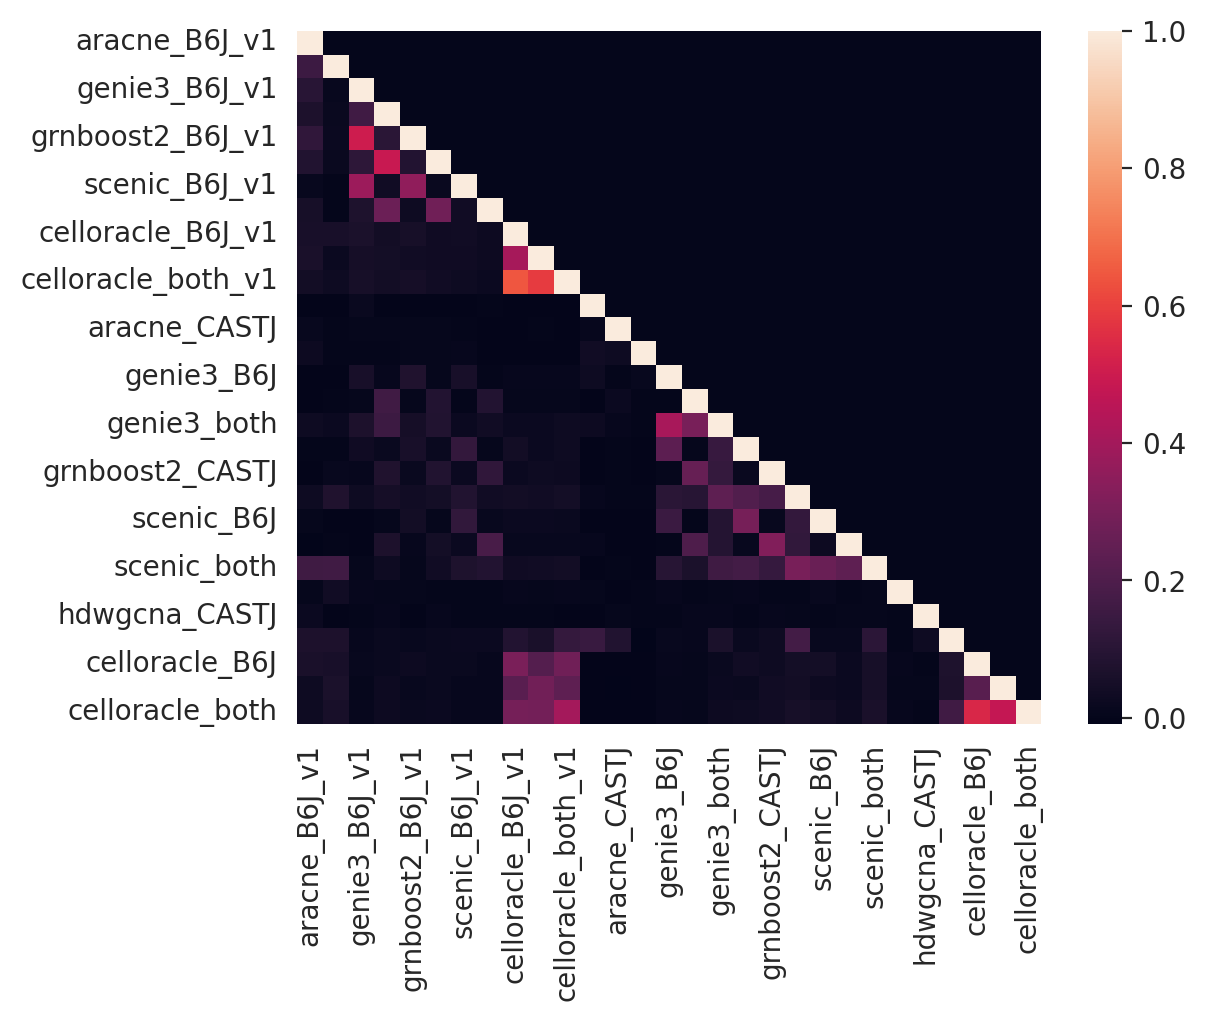

In [177]:
sns.heatmap(weighted_directed_corr_df.fillna(0))

In [176]:
weighted_directed_corr_df

,aracne_B6J_v1,aracne_CASTJ_v1,genie3_B6J_v1,genie3_CASTJ_v1,grnboost2_B6J_v1,grnboost2_CASTJ_v1,scenic_B6J_v1,scenic_CASTJ_v1,celloracle_B6J_v1,celloracle_CASTJ_v1,...,grnboost2_both,scenic_B6J,scenic_CASTJ,scenic_both,hdwgcna_B6J,hdwgcna_CASTJ,hdwgcna_both,celloracle_B6J,celloracle_CASTJ,celloracle_both
aracne_B6J_v1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
aracne_CASTJ_v1,0.149322,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
genie3_B6J_v1,0.100674,0.012796,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
genie3_CASTJ_v1,0.067188,0.017889,0.161172,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
grnboost2_B6J_v1,0.120342,0.020452,0.502607,0.103801,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
grnboost2_CASTJ_v1,0.080792,0.018555,0.110750,0.490294,0.084339,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
scenic_B6J_v1,0.014353,NaN,0.382144,0.038087,0.357797,0.016859,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
scenic_CASTJ_v1,0.052724,NaN,0.071948,0.269280,0.028315,0.282557,0.036303,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
celloracle_B6J_v1,0.054948,0.056810,0.062485,0.041692,0.052452,0.034045,0.037055,0.023600,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
celloracle_CASTJ_v1,0.059985,0.021174,0.047710,0.046001,0.037811,0.033833,0.031937,0.024922,0.405313,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [175]:
weighted_directed_corr_df.to_csv(os.path.join(output_dir, dataset, "pairwise_weighted_directed_corr.tsv"), sep="\t")

## Binarized directed comparisons

In [172]:
# Find pairwise distances of each row of the matrices, but don't include the diagonal or the upper triangle
bin_directed_dist_df = pd.DataFrame(
    index=list(bin_directed_mtx_dict.keys()),
    columns=list(bin_directed_mtx_dict.keys()), 
    data=np.zeros((len(bin_directed_mtx_dict.keys()), len(bin_directed_mtx_dict.keys())))
)
bin_directed_dist_dict = {}
for i in range(0, len(bin_directed_mtx_dict)):
    for j in range(0, len(bin_directed_mtx_dict)):
        if i <= j:
            run1 = list(bin_directed_mtx_dict.keys())[i]
            run2 = list(bin_directed_mtx_dict.keys())[j]
            print("Comparing " + run1 + " and " + run2)
            mtx1 = bin_directed_mtx_dict[run1]
            mtx2 = bin_directed_mtx_dict[run2]
            curr_dist_vec = (mtx1 != mtx2).sum(axis=1)
            bin_directed_dist_dict[run1 + "-" + run2] = curr_dist_vec
            bin_directed_dist_df[run1].loc[run2] = curr_dist_vec.sum()

Comparing aracne_B6J_v1 and aracne_B6J_v1
Comparing aracne_B6J_v1 and aracne_CASTJ_v1
Comparing aracne_B6J_v1 and genie3_B6J_v1
Comparing aracne_B6J_v1 and genie3_CASTJ_v1
Comparing aracne_B6J_v1 and grnboost2_B6J_v1
Comparing aracne_B6J_v1 and grnboost2_CASTJ_v1
Comparing aracne_B6J_v1 and scenic_B6J_v1
Comparing aracne_B6J_v1 and scenic_CASTJ_v1
Comparing aracne_B6J_v1 and celloracle_B6J_v1
Comparing aracne_B6J_v1 and celloracle_CASTJ_v1
Comparing aracne_B6J_v1 and celloracle_both_v1
Comparing aracne_B6J_v1 and aracne_B6J
Comparing aracne_B6J_v1 and aracne_CASTJ
Comparing aracne_B6J_v1 and aracne_both
Comparing aracne_B6J_v1 and genie3_B6J
Comparing aracne_B6J_v1 and genie3_CASTJ
Comparing aracne_B6J_v1 and genie3_both
Comparing aracne_B6J_v1 and grnboost2_B6J
Comparing aracne_B6J_v1 and grnboost2_CASTJ
Comparing aracne_B6J_v1 and grnboost2_both
Comparing aracne_B6J_v1 and scenic_B6J
Comparing aracne_B6J_v1 and scenic_CASTJ
Comparing aracne_B6J_v1 and scenic_both
Comparing aracne_B6J

In [178]:
bin_directed_dist_df

,aracne_B6J_v1,aracne_CASTJ_v1,genie3_B6J_v1,genie3_CASTJ_v1,grnboost2_B6J_v1,grnboost2_CASTJ_v1,scenic_B6J_v1,scenic_CASTJ_v1,celloracle_B6J_v1,celloracle_CASTJ_v1,...,grnboost2_both,scenic_B6J,scenic_CASTJ,scenic_both,hdwgcna_B6J,hdwgcna_CASTJ,hdwgcna_both,celloracle_B6J,celloracle_CASTJ,celloracle_both
aracne_B6J_v1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aracne_CASTJ_v1,316.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
genie3_B6J_v1,2198.0,2118.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
genie3_CASTJ_v1,2188.0,2118.0,2932.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
grnboost2_B6J_v1,2202.0,2114.0,1532.0,3174.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
grnboost2_CASTJ_v1,2186.0,2114.0,3280.0,1814.0,3366.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
scenic_B6J_v1,2234.0,2122.0,3456.0,3942.0,3484.0,3956.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
scenic_CASTJ_v1,2220.0,2122.0,3910.0,3668.0,3914.0,3616.0,3682.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
celloracle_B6J_v1,2204.0,2118.0,3710.0,3824.0,3742.0,3816.0,3738.0,3860.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
celloracle_CASTJ_v1,2194.0,2120.0,3772.0,3766.0,3782.0,3814.0,3812.0,3810.0,2426.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
links.filtered_links["aracne_B6J_v1"]

,source,target,weight,p,coef_abs
39,Zeb2,Srrm2,0.320225,1.883216e-08,1.000000e+00
38,Kmt2a,Son,0.276958,8.780056e-07,8.556310e-01
148,Klf12,Magi1,0.255286,1.883216e-08,7.833162e-01
34,Klf12,Hexb,0.253867,7.134293e-12,7.785819e-01
98,Zeb2,Cmss1,0.251620,1.321895e-03,7.710848e-01
...,...,...,...,...,...
202,Trerf1,Pbx1,0.030867,4.118942e-02,3.449043e-02
191,Mlxipl,Malat1,0.030758,1.321895e-03,3.412887e-02
100,Trps1,Arhgap15,0.028066,1.321895e-03,2.514410e-02
222,Rora,Kcnq5,0.026828,4.118942e-02,2.101473e-02


In [185]:
bin_directed_mtx_dict["aracne_B6J"].sum().sum()

2000.0

In [180]:
bin_directed_mtx_dict["celloracle_CASTJ_v1"]

,Zeb2,Srrm2,Kmt2a,Son,Klf12,Magi1,Hexb,Cmss1,Abca1,Celf2,...,Tent4b,Scfd2,Ppp1r12c,Cab39l,Arap1,Msrb2,Vdac2,Fam114a2,Bcl9l,Rala
Zeb2,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
Srrm2,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
Kmt2a,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
Son,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
Klf12,0.0,1.0,0,0.0,0,1.0,1.0,0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Msrb2,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
Vdac2,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
Fam114a2,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
Bcl9l,0.0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot: >

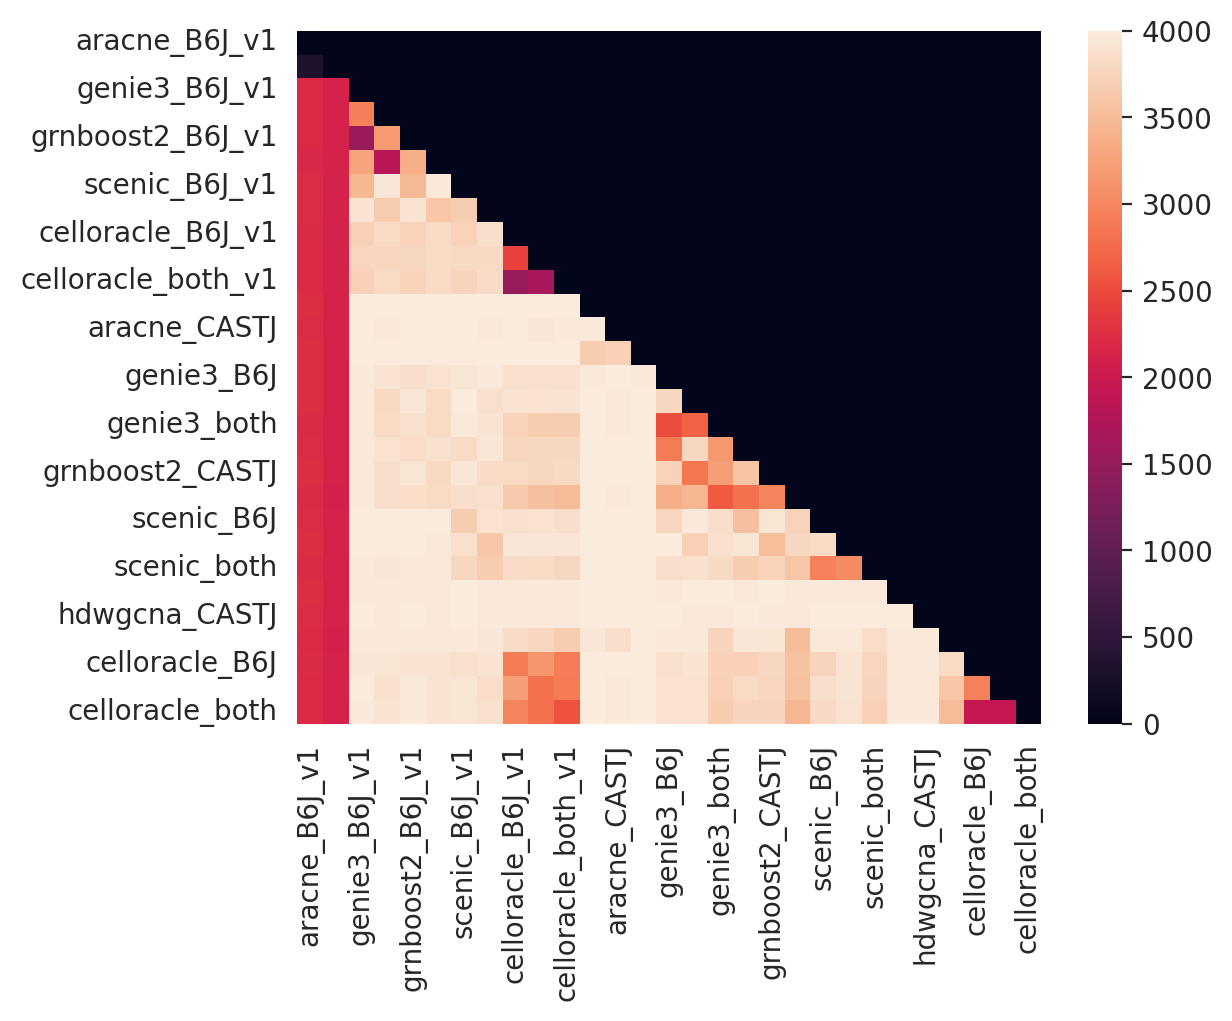

In [173]:
sns.heatmap(bin_directed_dist_df)

## Weighted undirected comparsions

In [ ]:
# Find pairwise correlations of each row of the matrices, but don't include the diagonal or the upper triangle
weighted_undirected_corr_df = pd.DataFrame(
    index=list(weighted_undirected_mtx_dict.keys()),
    columns=list(weighted_undirected_mtx_dict.keys()), 
    data=np.zeros((len(weighted_undirected_mtx_dict.keys()), len(weighted_undirected_mtx_dict.keys())))
)
weighted_undirected_corr_dict = {}
for i in range(0, len(weighted_undirected_mtx_dict)):
    for j in range(0, len(weighted_undirected_mtx_dict)):
        if i <= j:
            run1 = list(weighted_undirected_mtx_dict.keys())[i]
            run2 = list(weighted_undirected_mtx_dict.keys())[j]
            print("Comparing " + run1 + " and " + run2)
            mtx1 = weighted_undirected_mtx_dict[run1]
            mtx2 = weighted_undirected_mtx_dict[run2]
            curr_corr_vec = mtx1.corrwith(mtx2, axis = 1)
            weighted_undirected_corr_dict[run1 + "-" + run2] = curr_corr_vec
            weighted_undirected_corr_df[run1].loc[run2] = curr_corr_vec.mean()

In [ ]:
sns.heatmap(unweighted_directed_corr_df)

## Binarized undirected comparisons

In [ ]:
# Find pairwise distances of each row of the matrices, but don't include the diagonal or the upper triangle
bin_undirected_dist_df = pd.DataFrame(
    index=list(bin_undirected_mtx_dict.keys()),
    columns=list(bin_undirected_mtx_dict.keys()), 
    data=np.zeros((len(bin_undirected_mtx_dict.keys()), len(bin_undirected_mtx_dict.keys())))
)
bin_undirected_dist_dict = {}
for i in range(0, len(bin_undirected_mtx_dict)):
    for j in range(0, len(bin_undirected_mtx_dict)):
        if i <= j:
            run1 = list(bin_undirected_mtx_dict.keys())[i]
            run2 = list(bin_undirected_mtx_dict.keys())[j]
            print("Comparing " + run1 + " and " + run2)
            mtx1 = bin_undirected_mtx_dict[run1]
            mtx2 = bin_undirected_mtx_dict[run2]
            curr_dist_vec = (mtx1 != mtx2).sum(axis=1)
            bin_undirected_dist_dict[run1 + "-" + run2] = curr_dist_vec
            bin_undirected_dist_df[run1].loc[run2] = curr_dist_vec.sum()

,aracne_B6J_v1,aracne_CASTJ_v1,genie3_B6J_v1,genie3_CASTJ_v1,grnboost2_B6J_v1,grnboost2_CASTJ_v1
aracne_B6J_v1,0.0,0.0,0.0,0.0,0.0,0.0
aracne_CASTJ_v1,316.0,0.0,0.0,0.0,0.0,0.0
genie3_B6J_v1,2198.0,2118.0,0.0,0.0,0.0,0.0
genie3_CASTJ_v1,2188.0,2118.0,2932.0,0.0,0.0,0.0
grnboost2_B6J_v1,2202.0,2114.0,1532.0,3174.0,0.0,0.0
grnboost2_CASTJ_v1,2186.0,2114.0,3280.0,1814.0,3366.0,0.0


In [174]:
sns.heatmap(bin_undirected_dist_df)

NameError: name 'bin_undirected_dist_df' is not defined

In [149]:
bin_b6j_adj_mtx = bin_directed_mtx_dict["grnboost2_B6J_v1"]
bin_castj_adj_mtx = bin_directed_mtx_dict["grnboost2_CASTJ_v1"]

In [150]:
np.logical_and(bin_b6j_adj_mtx==1, bin_castj_adj_mtx==1).mean(axis=1).sort_values(ascending=False)

Rora      0.019135
Foxp1     0.018303
Celf4     0.011925
Msra      0.008597
Rbfox2    0.008042
            ...   
Csde1     0.000000
Ptpro     0.000000
Cep85l    0.000000
Usp33     0.000000
Rala      0.000000
Length: 3606, dtype: float64

In [151]:
(~(bin_b6j_adj_mtx == bin_castj_adj_mtx)).sum().sum()

3366

  0%|          | 0/29 [00:00<?, ?it/s]

aracne_B6J_v1


KeyboardInterrupt: 

In [48]:
b6j_links = links.filtered_links["grnboost2_B6J_v1"]
castj_links = links.filtered_links["grnboost2_CASTJ_v1"]

In [49]:
b6j_adj_mtx = links_to_adj_mtx(b6j_links, unique_genes, weight="coef_abs", edge_type="directed")
castj_adj_mtx = links_to_adj_mtx(castj_links, unique_genes, weight="coef_abs", edge_type="directed")

In [67]:
bin_b6j_adj_mtx = binarize_adj_mtx(b6j_adj_mtx)
bin_castj_adj_mtx = binarize_adj_mtx(castj_adj_mtx)

In [68]:
(b6j_adj_mtx.loc["Zeb2"] != 0).sum()

3606

In [58]:
test = 

In [65]:
test.sort_values(ascending=False).mean()

0.08433919419854848

In [56]:
b6j_adj_mtx.shape

(3606, 3606)

## Matrix differences

In [291]:
diff_adj = b6j_adj_list - castj_adj_list

In [292]:
def adj_mtx_to_list(adj_mtx):
    """Converts adjacency matrix to list of edges.

    Parameters
    ----------
    adj_mtx : pd.DataFrame
        Adjacency matrix of the graph. Index and columns are the nodes.
    
    Returns
    -------
    pd.DataFrame
        List of edges with columns 'source', 'target', and 'weight'.
    """
    adj_mtx = adj_mtx.copy()
    adj_mtx = adj_mtx.stack().reset_index()
    adj_mtx.columns = ['source', 'target', 'weight']
    adj_mtx = adj_mtx[adj_mtx['weight'] != 0]
    return adj_mtx

In [296]:
diff_list = adj_mtx_to_list(diff_adj)

In [302]:
diff_list["coef_abs"] = diff_list["weight"].abs()

In [303]:
diff_links = co.Links(name="test_diff", links_dict={"genotype_diff": diff_list})

In [304]:
diff_links.filter_links(p=None, threshold_number=10000)

In [305]:
diff_links.get_network_score()

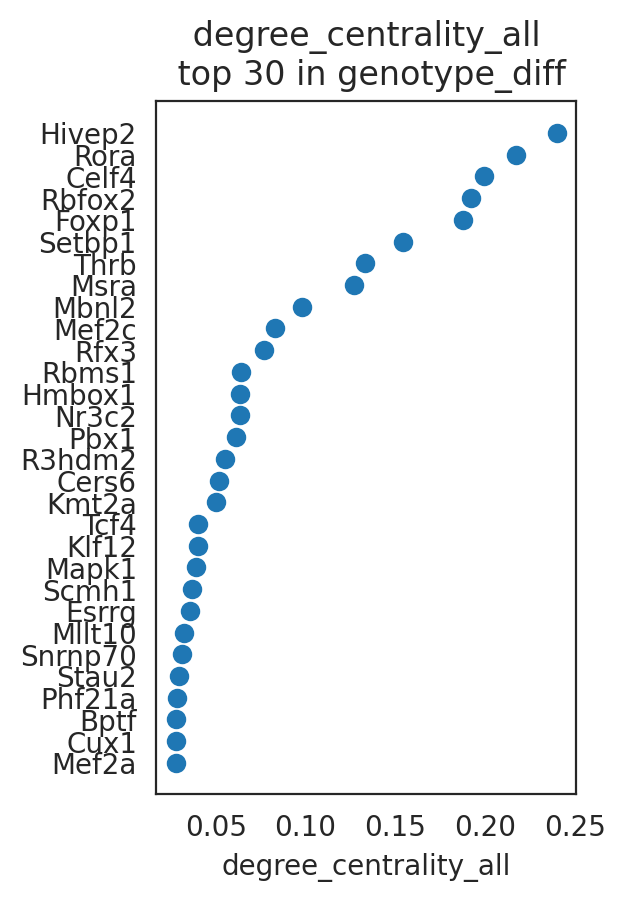

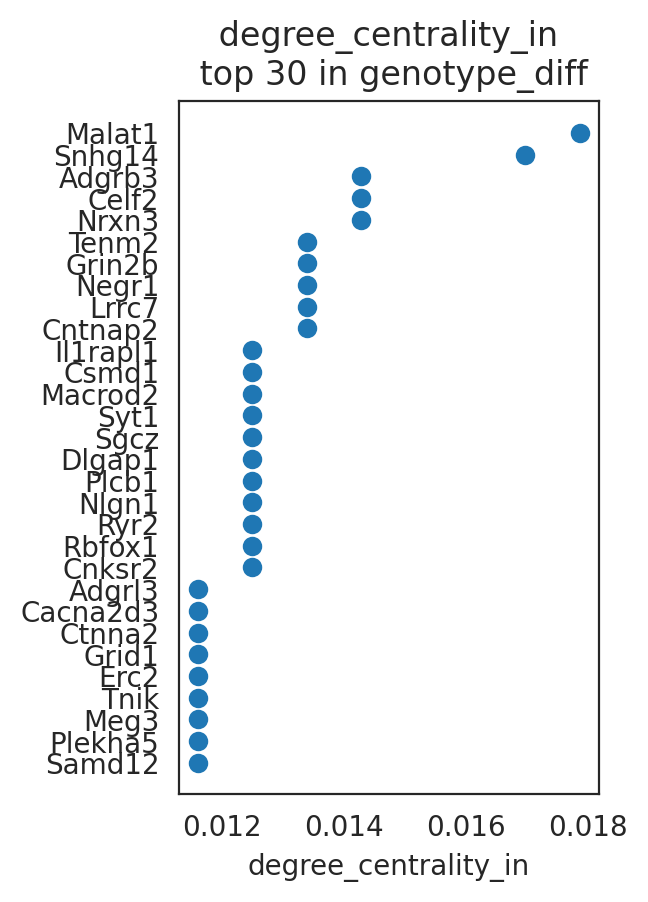

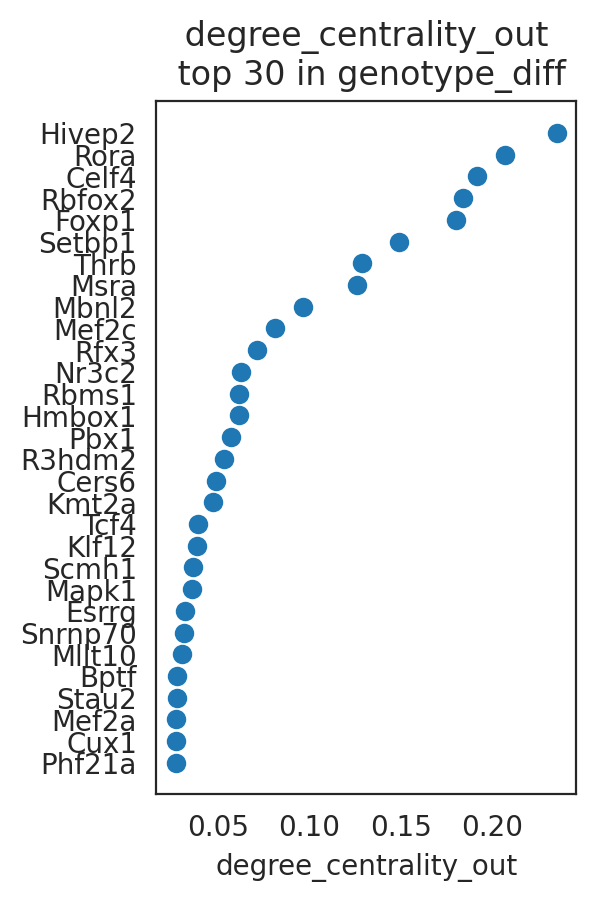

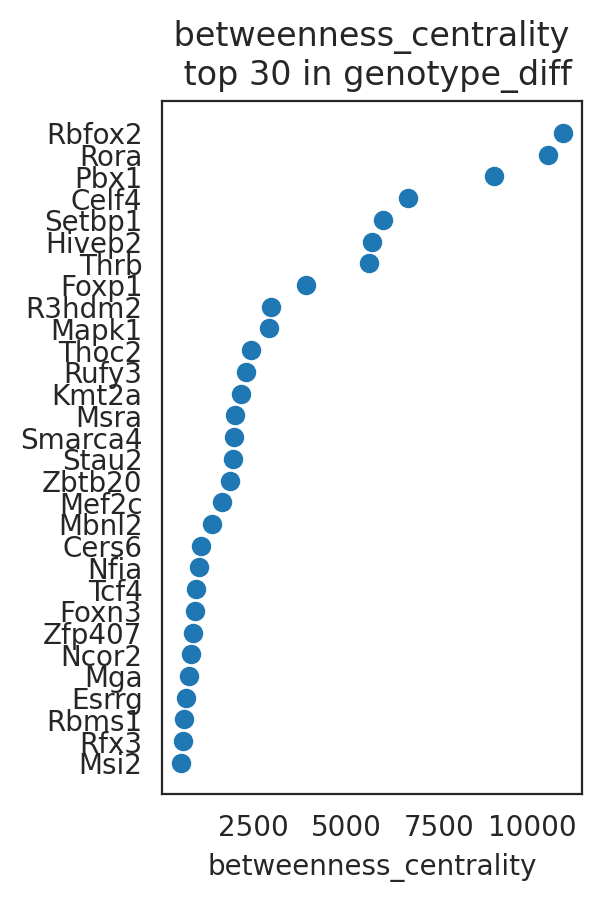

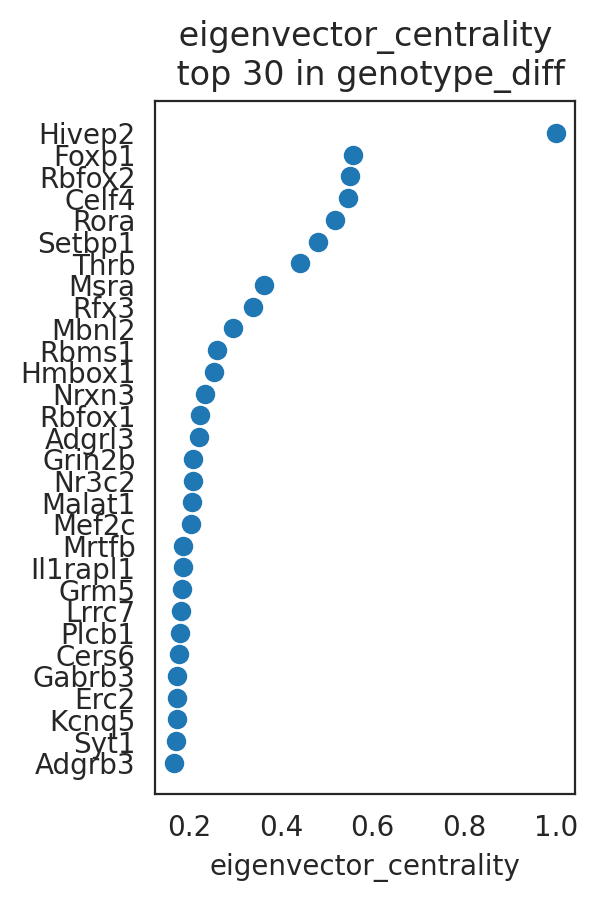

In [307]:
diff_links.plot_scores_as_rank(cluster="genotype_diff", n_gene=30)

In [76]:
b6_adj_list = links_to_adj(links.filtered_links["B6J"])

In [78]:
b6_adj_list.sum(axis=1).sort_values(ascending=False).head(10)

source
Hivep2    300
Celf4     200
Rbfox2    196
Setbp1    180
Thrb      176
Rora      158
Msra      114
Foxp1     102
Pbx1       58
Cers6      51
dtype: int64

In [80]:
b6_adj_list.sum(axis=0).sort_values(ascending=False).head(10)

target
Ptprn2                   11
Map2                     10
Gabrb3                   10
Macrod2                  10
ENSMUSG00000062991.10    10
Mdga2                     9
Grm7                      9
Gria2                     9
Anks1b                    9
Cntnap2                   9
dtype: int64

In [84]:
links.merged_score

,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,cluster
Rora,165,0.303867,7,0.012891,158,0.290976,1552.0,0.557437,B6J
Tnik,8,0.014733,8,0.014733,0,0.000000,0.0,0.147032,B6J
ENSMUSG00000062991.10,10,0.018416,10,0.018416,0,0.000000,0.0,0.154670,B6J
Lrrc4c,8,0.014733,8,0.014733,0,0.000000,0.0,0.144982,B6J
Msi2,34,0.062615,7,0.012891,27,0.049724,293.0,0.052578,B6J
...,...,...,...,...,...,...,...,...,...
Papola,1,0.001597,1,0.001597,0,0.000000,0.0,0.000019,CASTJ
Tmcc3,1,0.001597,1,0.001597,0,0.000000,0.0,0.000008,CASTJ
Rsf1,1,0.001597,1,0.001597,0,0.000000,0.0,0.002910,CASTJ
Klhdc10,1,0.001597,1,0.001597,0,0.000000,0.0,0.003818,CASTJ


In [ ]:
test = links_dict["aracne_CASTJ_v1"].sort_values("weight", ascending=False).head(2000)
test

,source,target,weight,p,coef_abs
48,Pbx1,Srrm2,0.266526,6.286646e-08,1.000000e+00
27,Zeb2,Celf2,0.243893,1.011566e-09,9.019062e-01
89,Kmt2a,Cst3,0.230978,1.678501e-04,8.459279e-01
116,Zeb2,Son,0.222300,6.962108e-03,8.083192e-01
56,Mlxipl,Sfi1,0.214902,1.461331e-11,7.762513e-01
...,...,...,...,...,...
92,Mlxipl,Fat3,0.047581,3.471661e-06,5.105832e-02
38,Rora,Celf2,0.047167,3.471661e-06,4.926440e-02
71,Gas7,Srgap2,0.045404,6.962108e-03,4.162064e-02
95,Kmt2a,Malat1,0.041534,6.962108e-03,2.485003e-02


In [ ]:
g = Graph.DataFrame(test[["source", "target"]], directed=True, use_vids=False)
g.es["weight"] = test["coef_abs"].values.copy()
df = g.get_vertex_dataframe()
# Calculate scores
for i in ["all", "in", "out"]:
    df[f"degree_{i}"] = g.degree(mode=i)
    df[f"degree_centrality_{i}"] = df[f"degree_{i}"] / (df.shape[0]-1)
df["betweenness_centrality"] = g.betweenness(directed=True, weights="weight")
df["eigenvector_centrality"] = g.eigenvector_centrality(directed=False, weights="weight")

In [ ]:
df.sort_values("degree_all", ascending=False).head(10)

,name,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality
vertex ID,,,,,,,,,
7,Mlxipl,45,0.584416,1,0.012987,44,0.571429,84.0,1.000000
4,Kmt2a,32,0.415584,1,0.012987,31,0.402597,82.0,0.515222
0,Pbx1,23,0.298701,2,0.025974,21,0.272727,60.0,0.761577
2,Zeb2,21,0.272727,2,0.025974,19,0.246753,58.0,0.578436
1,Srrm2,5,0.064935,5,0.064935,0,0.000000,0.0,0.539570
5,Cst3,4,0.051948,4,0.051948,0,0.000000,0.0,0.444597
16,Cdk8,3,0.038961,3,0.038961,0,0.000000,0.0,0.195838
25,Ly86,3,0.038961,3,0.038961,0,0.000000,0.0,0.245838
30,Dgki,3,0.038961,3,0.038961,0,0.000000,0.0,0.172402
